### 🧭 Notebook 03 – Evaluating GANs & Common Challenges ###

---

#### **1. Notebook Overview**

In the previous notebook, we built and trained a **Deep Convolutional GAN (DCGAN)** using a downsampled and balanced **WikiArt subset**.  
We observed how convolutional architectures helped improve **texture fidelity, structural coherence,** and **artistic realism** compared to the fully connected GAN from Notebook 1.

Now, a new question arises — **how do we evaluate a GAN’s performance?**

Unlike classifiers, GANs lack a straightforward metric such as accuracy or F1-score.  
Their losses do not directly indicate *visual quality*. Instead, evaluating a generative model means **judging** how realistic, diverse, and stable its outputs are — through both **quantitative** and **qualitative** lenses.


**🎯 Purpose of This Notebook**

This notebook focuses on developing intuition for **GAN evaluation** and understanding **common failure modes**, including:
- **Mode collapse:** when the generator produces near-identical outputs.
- **Training instability:** when the adversarial balance between generator and discriminator breaks down.
- **Loss of diversity:** when the generator ignores style or color variations present in real data.

We will use a **pretrained DCGAN** (trained offline on the WikiArt subset) to:
- Visually compare generations from early, mid, and final training epochs.  
- Explore **latent space diversity** and style variation.  
- Discuss **qualitative evaluation frameworks** for judging “good” generative results.


**🧠 Core Evaluation Dimensions**

We will analyze GAN performance along three complementary dimensions:

1. **Quality** — Are the generated artworks visually coherent and stylistically convincing?  
2. **Diversity** — Do the generations represent multiple artistic styles, color palettes, and compositions?  
3. **Stability** — Does the generator improve steadily, or does it oscillate or collapse during training?

Together, these aspects help us reason about a GAN’s *learning dynamics* beyond raw loss values.


**📦 Note on Model and Dataset**

> We will use the **pretrained DCGAN** trained on a **balanced WikiArt subset**  
> (~8–10 k samples spanning six major art styles).  
> This compact dataset allows us to perform experiments efficiently while maintaining stylistic diversity.


**By the end of this notebook, we will be able to:**
- Identify visual and training cues of stable vs. unstable GAN learning.  
- Evaluate the generator’s artistic quality and variety through curated samples.  
- Appreciate why evaluating GANs is as much an **art** as it is a **science**.

---


#### **2. Why Evaluating GANs Is Hard**

In the previous section, we recognized that assessing GANs goes far beyond tracking losses or accuracy.  
Here, we unpack **why** evaluating Generative Adversarial Networks (GANs) is inherently challenging — both mathematically and perceptually.

Evaluating **GANs** is fundamentally more complex than evaluating supervised models such as classifiers or regressors.  
While in classification we can directly measure *accuracy*, *precision*, or *loss*, GANs do not optimize an explicit objective that corresponds to any measurable real-world metric.  
Their goal is to **generate data indistinguishable from reality** — but *how do we quantify “realistic”?*

**No Explicit Likelihood or Reconstruction Loss**

Unlike **Variational Autoencoders (VAEs)**, which include a reconstruction loss that measures how well the output matches the input,  
GANs **do not model data likelihood** directly.  
There is no single scalar metric that tells us whether the generator has truly captured the data distribution.

Mathematically, the GAN objective is:

$$
\min_G \max_D V(D, G) = 
\mathbb{E}_{x \sim p_{data}} [\log D(x)] +
\mathbb{E}_{z \sim p_z} [\log (1 - D(G(z)))]
$$

This *adversarial min–max game* measures how effectively $G$ can fool $D$,  
but it **does not directly reflect visual quality** or the diversity of generated images.

**The Subjectivity of “Realism”**

What does *realistic* even mean in the context of art?

- A perfectly blended color palette?  
- A composition that mimics brush strokes of real paintings?  
- Or something that evokes human emotion or aesthetic appeal?

Unlike datasets containing faces or everyday objects, **artistic realism is subjective and multidimensional**.  
Perception of realism depends on human taste, artistic conventions, and cultural interpretation — making objective evaluation nearly impossible.

**Qualitative Aspects of GAN Evaluation**

Because of these inherent challenges, we rely heavily on **qualitative indicators** to understand how well a GAN performs.  
Three aspects are most commonly used:

- **Visual Quality** – Sharpness, coherence, and structural integrity of generated images.  
  Does each image *look like* it belongs to the target artistic style?

- **Diversity** – Variety across generated samples.  
  Does the generator produce diverse brush strokes, color schemes, and compositions?

- **Mode Coverage** – Representation of multiple “modes” or categories in the data.  
  For example, if we trained on six art styles, does the generator produce outputs from all of them — or collapse into one dominant mode?


**The GAN Evaluation Triangle**

These three aspects — **realism**, **diversity**, and **stability** — often exist in **tension**.  
Improving one can sometimes degrade the others.  
For instance, pushing too hard for image sharpness might cause mode collapse, while encouraging too much diversity might reduce realism.

The trade-off can be visualized as a conceptual triangle:

```text
           +---------------------+
           |      REALISM        |
           |   (Image Quality)   |
           +---------------------+
                   /\
                  /  \
                 /    \
       DIVERSITY ------ STABILITY
   (Variety)              (Training Balance)
```

- If we push too hard for realism, we may lose diversity (mode collapse).
- If we push for diversity, we risk losing stability or sharpness.
- The art of training GANs lies in finding an equilibrium among all three.

**🧩 Reflection**

> Evaluating GANs is as much about observation and interpretation as about metrics.
> As we continue, we’ll visualize outputs, compare epochs, and interpret latent space diversity — all of which will help us understand the behavior of our GAN beyond numbers.

---

#### **3. Setup and Load Pretrained DCGAN**

Before we begin evaluating, we first need to **set up the environment** and **load our pretrained DCGAN model**.  
This model was trained offline on the **downsampled WikiArt subset** — approximately 8–10k balanced samples across six distinct art styles.

By using pretrained weights, we can instantly explore **high-quality artistic outputs** and focus on understanding *how to evaluate them* rather than waiting for lengthy training runs.

**🧠 Why Use a Pretrained Model?**

- Training GANs from scratch is computationally expensive and often unstable on CPUs.  
- A pretrained model provides **consistent, high-quality generations**, making it ideal for studying *quality*, *diversity*, and *style representation*.  
- It represents a **well-trained equilibrium** between Generator and Discriminator, giving us a realistic baseline for evaluation.


**🧩 Steps in This Section**

1. Load the pretrained **GeneratorDCGAN** model.  
2. Prepare a small batch of real images from the WikiArt subset for comparison.  
3. Generate 16–25 **synthetic art images** using random latent vectors.  
4. Visualize the generated samples in a grid for qualitative inspection.

C:\Users\noman\AppData\Local\Temp\ipykernel_30796\2310744203.py:54: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load("dcgan_pretrained.pth", map_location=dev

✅ Pretrained DCGAN Generator loaded successfully with feature_g=32.


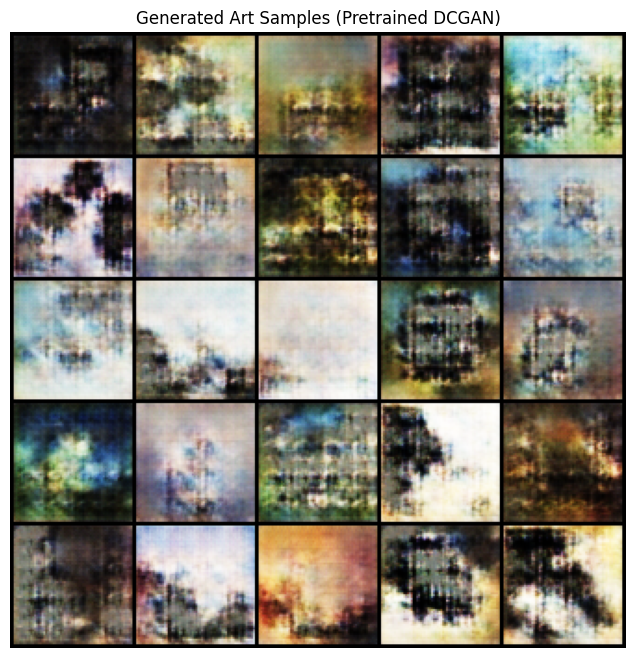

In [10]:
# --- Imports and setup ---
import torch
from torchvision import datasets, transforms, utils
import matplotlib.pyplot as plt
import numpy as np
from torch import nn

# --- Device setup ---
device = "cuda" if torch.cuda.is_available() else "cpu"

# --- Transformations for dataset ---
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# --- Load the WikiArt subset (already balanced & downsampled) ---
data_path = "WikiartSubsetDataset/train"  # adjust path if needed
dataset = datasets.ImageFolder(root=data_path, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

# --- Define DCGAN Generator architecture ---
class GeneratorDCGAN(nn.Module):
    def __init__(self, z_dim=100, feature_g=64, channels_img=3):
        super().__init__()
        self.net = nn.Sequential(
            nn.ConvTranspose2d(z_dim, feature_g*8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(feature_g*8),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(feature_g*8, feature_g*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_g*4),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(feature_g*4, feature_g*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_g*2),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(feature_g*2, feature_g, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_g),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(feature_g, channels_img, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.net(x)

# --- Load pretrained model (match channels to checkpoint) ---
G_pretrained = GeneratorDCGAN(z_dim=100, feature_g=32, channels_img=3).to(device)
state = torch.load("dcgan_pretrained.pth", map_location=device)
G_pretrained.load_state_dict(state, strict=True)
G_pretrained.eval()
print("✅ Pretrained DCGAN Generator loaded successfully with feature_g=32.")


# --- Generate random art samples ---
z = torch.randn(25, 100, 1, 1, device=device)
with torch.no_grad():
    fake_images = G_pretrained(z).detach().cpu()

# --- Denormalize and visualize ---
grid = utils.make_grid(fake_images, nrow=5, normalize=True)
plt.figure(figsize=(8, 8))
plt.imshow(np.transpose(grid, (1, 2, 0)))
plt.axis("off")
plt.title("Generated Art Samples (Pretrained DCGAN)")
plt.show()


**🖼️ Reflection**

>How do we visually judge quality and diversity?
>- Are the generated paintings sharp and detailed (quality)?
>- Do they exhibit different colors, brush strokes, and compositions (diversity)?
>- Can we intuitively link any generated samples to specific art styles seen in the real WikiArt subset?

As we proceed, we’ll formalize these intuitions into more structured evaluation approaches.

---

#### **4. Visual Comparison Across Epochs**

One of the most insightful ways to understand **how GANs learn** is to **observe their visual evolution over epochs**.  
Unlike conventional neural networks—where decreasing loss usually signals improvement—GANs often **oscillate** or **destabilize** during training.  
Hence, visual progression offers a more reliable lens into what the generator is actually learning.

**🎯 Goal**

We will compare outputs from three versions of the **DCGAN Generator**:

- `dcgan_epoch1.pth` → *Early stage:* random-like blobs and color noise  
- `dcgan_epoch5.pth` → *Mid stage:* emerging structure and texture hints  
- `dcgan_pretrained.pth` → *Late stage:* refined, coherent, and stylistically rich results  

By generating all images from the **same latent vectors $z$**, we can clearly see how the generator gradually learns to:
- Capture **global structure** before local detail.  
- Refine **color harmony, edges, and texture coherence**.  

C:\Users\noman\AppData\Local\Temp\ipykernel_30796\2352265111.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path, map_location=de

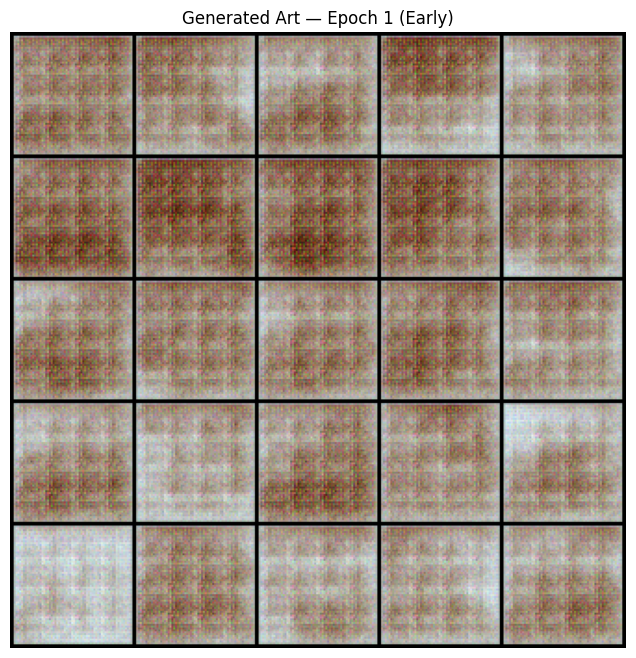

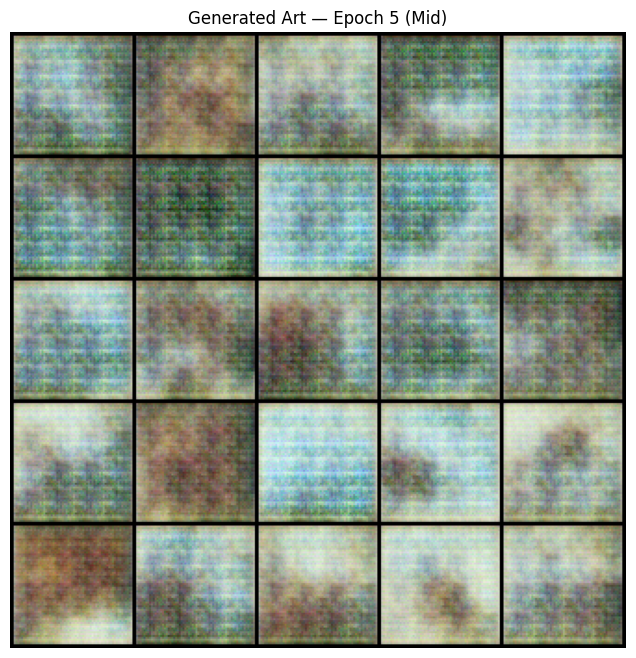

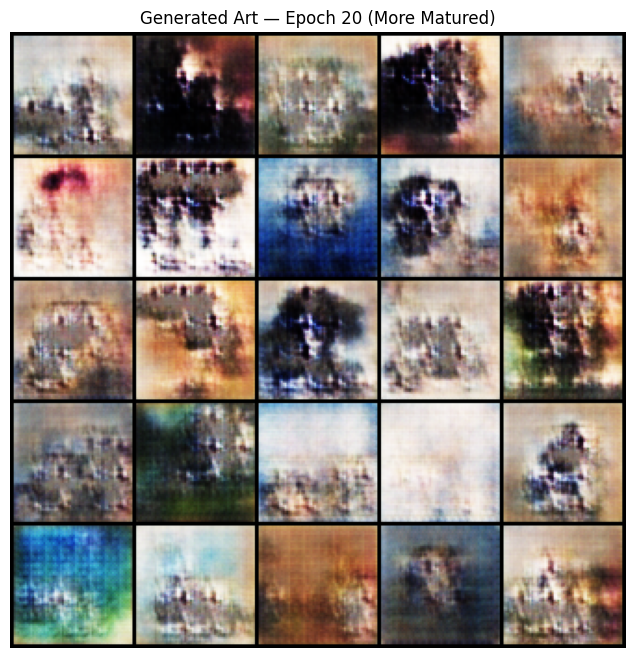

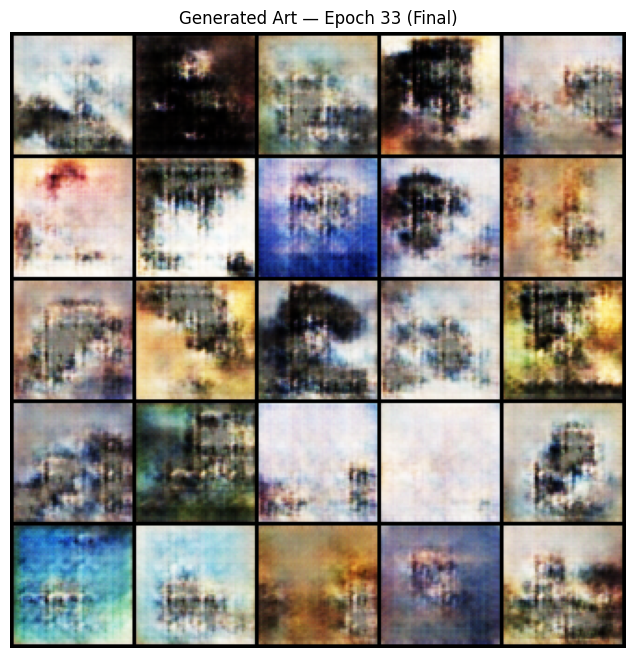

In [6]:
# --- Helper: visualize a batch as grid ---
def show_grid(images, title, nrow=5):
    grid = utils.make_grid(images, nrow=nrow, normalize=True)
    plt.figure(figsize=(8, 8))
    plt.imshow(np.transpose(grid, (1, 2, 0)))
    plt.axis("off")
    plt.title(title)
    plt.show()

# --- Fixed latent vectors for consistent comparison ---
torch.manual_seed(42)
fixed_z = torch.randn(25, 100, 1, 1, device=device)

# --- Function to load a checkpoint and generate images ---
def generate_from_checkpoint(ckpt_path):
    model = GeneratorDCGAN(z_dim=100, feature_g=32).to(device)
    model.load_state_dict(torch.load(ckpt_path, map_location=device))
    model.eval()
    with torch.no_grad():
        imgs = model(fixed_z).detach().cpu()
    return imgs

# --- Compare across epochs ---
checkpoints = {
    "Epoch 1 (Early)": "dcgan_epoch1.pth",
    "Epoch 5 (Mid)": "dcgan_epoch5.pth",
    "Epoch 20 (More Matured)": "dcgan_epoch20.pth",
    "Epoch 33 (Final)": "dcgan_pretrained.pth"
}

for stage, path in checkpoints.items():
    imgs = generate_from_checkpoint(path)
    show_grid(imgs, f"Generated Art — {stage}")

**🧩 Observations**

| Epoch               | Expected Characteristics                              |
| :------------------ | :---------------------------------------------------- |
| **1**               | Noisy blobs, unstructured colors, low contrast.       |
| **5**               | Emergence of basic shapes and texture hints.          |
| **20 or 33** | Distinct composition, clear brushwork, color harmony. |

---


#### **5. Understanding Mode Collapse**

**What is mode collapse (and why we care)?**  
In a balanced art dataset, we expect our generator $G$ to produce **diverse** paintings: different styles, palettes, brush textures, and compositions.  
**Mode collapse** happens when $G$ maps many different latent vectors $z \sim \mathcal{N}(0, I)$ to **very similar outputs** (e.g., the same color blobs or a single recurring composition).  

**Intuition:**  
- If the Discriminator $D$ provides **strong gradients** for one particular kind of image, $G$ can learn a “shortcut”: produce only that kind of image to fool $D$.  
- This **imbalance** in the adversarial game reduces diversity: $G$ “wins” locally but **fails** to represent the full data distribution.

**What to look for in practice:**  
- Many samples that look **nearly identical** even when $z$ changes.  
- Repetition of the **same color palette** or **layout** across batches.

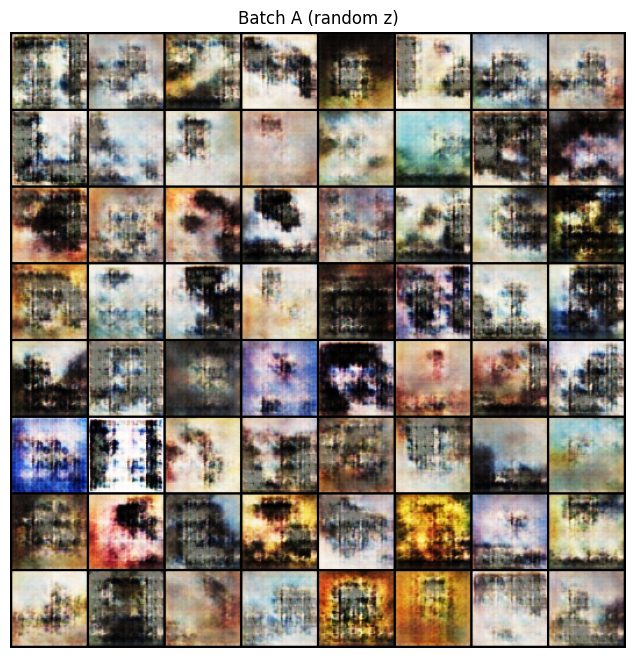

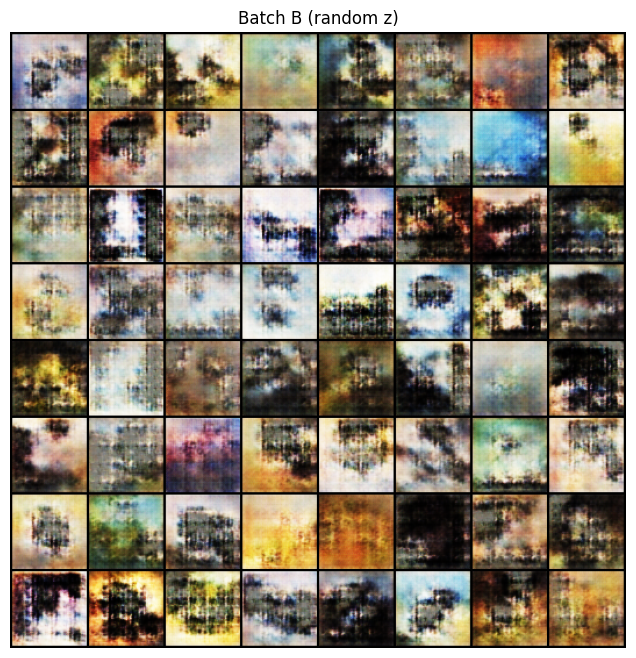

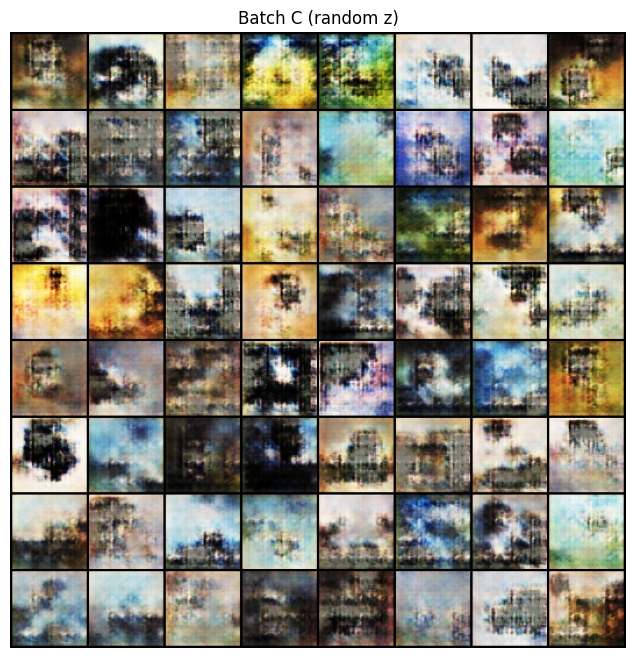

Diversity heuristics (higher std, lower cosine similarity are better):
Batch A: pixel_std=0.2568, mean_cos_sim=0.1320
Batch B: pixel_std=0.2626, mean_cos_sim=0.1585
Batch C: pixel_std=0.2527, mean_cos_sim=0.1283


In [11]:
# --- Code demo: sample many z’s and check for repetition visually and with simple diversity heuristics ---

import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

# We assume a trained/pretrained generator is available as G (or G_pretrained).
# Prefer the pretrained one for a strong baseline; replace if needed.
assert 'G_pretrained' in globals() or 'G' in globals(), "Load a generator first (e.g., Section 2)."
G_eval = G_pretrained if 'G_pretrained' in globals() else G
G_eval.eval()

device = next(G_eval.parameters()).device
latent_dim = 100

# Helper: denormalize from [-1,1] to [0,1]
def denorm(x): 
    return (x + 1) / 2

# 1) VISUAL CHECK — generate multiple batches of samples
def show_batch(title, imgs, nrow=8):
    grid = torchvision.utils.make_grid(denorm(imgs).cpu(), nrow=nrow, padding=2, normalize=False)
    plt.figure(figsize=(8, 8))
    plt.imshow(np.transpose(grid.numpy(), (1, 2, 0)))
    plt.title(title)
    plt.axis("off")
    plt.show()

with torch.no_grad():
    # Generate 3 different batches from different z’s
    batch_sizes = [64, 64, 64]
    z1 = torch.randn(batch_sizes[0], latent_dim, 1, 1, device=device)
    z2 = torch.randn(batch_sizes[1], latent_dim, 1, 1, device=device)
    z3 = torch.randn(batch_sizes[2], latent_dim, 1, 1, device=device)

    f1 = G_eval(z1)
    f2 = G_eval(z2)
    f3 = G_eval(z3)

show_batch("Batch A (random z)", f1, nrow=8)
show_batch("Batch B (random z)", f2, nrow=8)
show_batch("Batch C (random z)", f3, nrow=8)

# 2) SIMPLE DIVERSITY HEURISTICS (no heavy dependencies)
#    - Pixelwise std across the batch (higher is better)
#    - Mean pairwise cosine similarity between flattened images (lower is better)

def batch_diversity_scores(imgs):
    # imgs: (N, 3, 64, 64) in [-1,1]
    x = denorm(imgs).clamp(0,1)                      # (N,3,64,64) in [0,1]
    x_np = x.cpu().numpy()
    N = x_np.shape[0]

    # Pixelwise std aggregated
    std_per_pixel = x_np.std(axis=0)                 # (3,64,64)
    mean_pixel_std = std_per_pixel.mean()            # scalar

    # Mean pairwise cosine similarity on flattened vectors
    X = x.view(N, -1)                                # (N, 3*64*64)
    X = X - X.mean(dim=1, keepdim=True)              # zero-center each sample
    X = X / (X.norm(dim=1, keepdim=True) + 1e-8)     # l2-normalize
    sims = []
    for i in range(N):
        # compare with 10 random others to keep it light
        idxs = torch.randint(low=0, high=N, size=(10,))
        dot = (X[i, None, :] * X[idxs, :]).sum(dim=1)  # cosine similarity
        sims.append(dot.mean().item())
    mean_cos_sim = float(np.mean(sims))

    return mean_pixel_std, mean_cos_sim

with torch.no_grad():
    s1 = batch_diversity_scores(f1)
    s2 = batch_diversity_scores(f2)
    s3 = batch_diversity_scores(f3)

print("Diversity heuristics (higher std, lower cosine similarity are better):")
print(f"Batch A: pixel_std={s1[0]:.4f}, mean_cos_sim={s1[1]:.4f}")
print(f"Batch B: pixel_std={s2[0]:.4f}, mean_cos_sim={s2[1]:.4f}")
print(f"Batch C: pixel_std={s3[0]:.4f}, mean_cos_sim={s3[1]:.4f}")

**How to interpret the results**

- **Visual inspection:**  
  If many samples look **very similar** (same colors, same blobs, same layout) across different $z$ values, that’s a red flag for **mode collapse**.

- **Heuristics:**  
  - **Pixel std across the batch** (scalar):  
    Higher values usually indicate **greater variety** across samples.  
  - **Mean pairwise cosine similarity** (scalar):  
    Lower values usually indicate **less redundancy** (i.e., images are more distinct).

These are **lightweight checks** (not formal metrics like FID/IS), but they help us sense whether diversity is present.

**Reflection**

- *“Why might the generator settle into repeating patterns?”*  
  Because $G$ can find a **locally easy strategy** that reliably fools $D$ (e.g., one texture/shape), and $D$ may not penalize lack of variety strongly enough. This is often caused by **training imbalance**, poorly tuned learning rates, or weak regularization.

- *“How could we detect and mitigate this in practice?”*  
  **Detect:** Visual grids, diversity heuristics, epoch-to-epoch comparison, class-conditional checks (if labels exist).  
  **Mitigate:**  
  - Adjust learning rates (often lower $D$’s LR or raise $G$’s LR slightly).  
  - Use **label smoothing**, **instance noise**, or **data augmentation** for $D$.  
  - Try **mini-batch discrimination** (explicitly encourages sample diversity).  
  - Increase **model capacity** or move to stronger architectures (e.g., StyleGAN variants) when resources allow.  
  - Ensure **balanced data** so $G$ is exposed to varied modes.  

Understanding mode collapse is central to training **creative, diverse** generative models — a key theme as we continue evaluating our GANs.

---

#### **6. Comparing Generated vs. Real Images**

Now that we’ve analyzed how GANs evolve, let’s directly compare **generated** images with **real artwork** from the WikiArt dataset.  

Our goal here is not to assign a numeric score but to **visually and intuitively** assess how close the generator comes to the true artistic data distribution.

**A. Load a Small Set of Real WikiArt Samples**

We’ll reuse the same preprocessing pipeline as our training setup to ensure fair visual comparison.


In [ ]:
# Load a small batch of real images from the WikiArt subset (validation/test split)
import torchvision
from torchvision import transforms

# Ensure same preprocessing as training
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Assuming 'wikiart_test_dir' points to test/validation subset
wikiart_test_dir = "WikiartSubsetDataset/train"  # adjust path if needed
real_dataset = torchvision.datasets.ImageFolder(root=wikiart_test_dir, transform=transform)
real_loader = torch.utils.data.DataLoader(real_dataset, batch_size=16, shuffle=True)

real_imgs, _ = next(iter(real_loader))
print(f"Loaded {real_imgs.size(0)} real samples for comparison.")

Loaded 16 real samples for comparison.


**B. Generate a Matching Set of Fake Images**

We’ll sample from the same latent distribution as before and generate an equal number of synthetic artworks using our pretrained DCGAN.


In [ ]:
# Generate fake samples (same batch size as real images)
torch.manual_seed(42)
z = torch.randn(real_imgs.size(0), 100, 1, 1, device=device)
fake_imgs = G_pretrained(z).detach().cpu()

**C. Display Side-by-Side Comparison**

We’ll now create two grids — one for real paintings, one for generated ones.  
Visually inspect aspects like:
- Brush stroke textures  
- Color palettes  
- Composition and edges  
- Artistic coherence


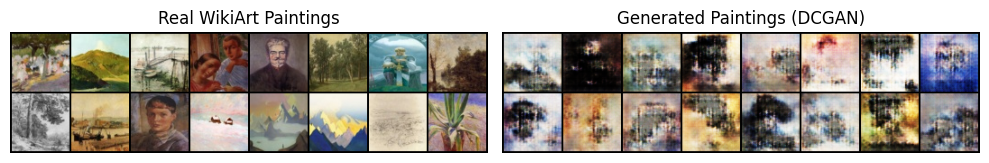

In [ ]:
# Helper for visualization
def show_comparison_grid(real, fake, nrow=8):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    grid_real = torchvision.utils.make_grid((real + 1)/2, nrow=nrow, padding=2)
    grid_fake = torchvision.utils.make_grid((fake + 1)/2, nrow=nrow, padding=2)

    axes[0].imshow(np.transpose(grid_real.numpy(), (1, 2, 0)))
    axes[0].set_title("Real WikiArt Paintings")
    axes[0].axis("off")

    axes[1].imshow(np.transpose(grid_fake.numpy(), (1, 2, 0)))
    axes[1].set_title("Generated Paintings (DCGAN)")
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()

show_comparison_grid(real_imgs[:16], fake_imgs[:16])

**D. Optional: Mixed Real + Fake Challenge**

Let’s randomly mix real and fake samples together and try to **guess** which are real vs. generated — a simple “**Visual Turing Test**.”

When a GAN performs well, this becomes surprisingly difficult.

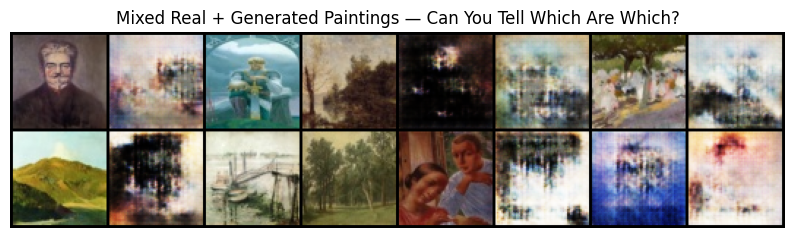

Label order (for instructor validation):
('Real', 'Fake', 'Real', 'Real', 'Fake', 'Fake', 'Real', 'Fake', 'Real', 'Fake', 'Real', 'Real', 'Real', 'Fake', 'Fake', 'Fake')


In [ ]:
# Optional: Shuffle real + fake images
import random

all_imgs = torch.cat([real_imgs[:8], fake_imgs[:8]], dim=0)
labels = ["Real"] * 8 + ["Fake"] * 8

# Shuffle jointly
combined = list(zip(all_imgs, labels))
random.shuffle(combined)
shuffled_imgs, shuffled_labels = zip(*combined)

grid_mix = torchvision.utils.make_grid((torch.stack(shuffled_imgs) + 1)/2, nrow=8, padding=2)
plt.figure(figsize=(10, 5))
plt.imshow(np.transpose(grid_mix.numpy(), (1, 2, 0)))
plt.axis("off")
plt.title("Mixed Real + Generated Paintings — Can You Tell Which Are Which?")
plt.show()

# Display label key (for instructor reference)
print("Label order (for instructor validation):")
print(shuffled_labels)

**E. Reflection and Discussion**

- *“Can we visually separate real vs. fake paintings?”*  
  Observe whether generated samples blend seamlessly or still appear artificial.  
  If most viewers can’t easily tell, the GAN is achieving **visual plausibility**.

- *“What artistic details still differ?”*  
  Look for subtle aspects: brush strokes, edges, fine gradients, or compositional balance.  
  GANs often capture **color distribution and rough form**, but may lack **texture coherence** or **semantic depth**.

**Summary Insight**

| Aspect | Real WikiArt | Generated (DCGAN) | Observations |
|:--------|:--------------|:------------------|:--------------|
| Color Palette | Natural, balanced | Sometimes over-saturated | Needs better regularization |
| Texture Detail | Fine brushwork | Smoothed or repetitive | Limited texture realism |
| Composition | Structured | Slightly abstract or repetitive | Potential mode collapse |
| Overall Impression | Artistic and varied | Convincing but less nuanced | Promising realism; room for diversity |

This final comparison highlights how **GAN evaluation** ultimately blends **quantitative metrics** and **human aesthetic judgment** — reminding us why GANs sit at the intersection of **science and creativity**.

---

#### **7. Summary and Reflection**

We have now explored how to evaluate the performance and behavior of a trained GAN.  
Unlike classifiers or regressors, GANs don’t produce an explicit accuracy or loss-based metric that neatly reflects quality. Evaluating them requires a mix of **quantitative understanding** and **qualitative judgment**.

**Key Takeaways**

- There is **no single objective accuracy metric** for GANs.  
  The adversarial setup means both the generator and discriminator are locked in a dynamic balance, making traditional metrics like loss or accuracy unreliable indicators of progress.

- **Qualitative and diversity-based evaluations** are essential.  
  We assess generated samples by observing their **visual quality**, **variety**, and **faithfulness** to real data distributions. Smooth latent traversals and diverse outputs signal a healthy generator.

- **Common issues to watch for:**  
  - *Mode Collapse*: generator produces limited variations of images.  
  - *Training Instability*: discriminator–generator dynamics oscillate or diverge.  
  - *Overfitting to Discriminator*: generator learns to exploit discriminator weaknesses rather than improving realism.

These challenges remind us that **GAN evaluation is as much art as it is science**.

**Forward Link**

In **Notebook 4**, we will move from evaluation to **creative exploration**.  
We will experiment with *latent interpolation*, *style blending*, and *generative art creation*, seeing how the GAN’s latent space can be guided toward intentional, aesthetic outcomes.

**Reflection Question**

*What makes an AI-generated image “artistically good”?*  
Is it about **realism**, where the image looks convincingly human-made?  
Is it **novelty**, where the output reveals something unexpected or fresh?  
Or is it **emotional resonance**, where the image evokes feeling or meaning despite being synthetic?

There may be no single answer — and that ambiguity is precisely what makes GANs fascinating to study.
